In [1]:
import re, os
import pandas as pd
import numpy as np
import json
from pathlib import Path
from glob import glob
from tqdm import tqdm
import pickle
import time

def writePickle(file_path, sth):
    # store list in binary file so 'wb' mode
    with open(file_path, 'wb') as fp:
        pickle.dump(sth, fp)

def loadPickle(file_path):
    # for reading also binary mode is important
    with open(file_path, 'rb') as fp:
        return pickle.load(fp)

import sys
sys.path.append("/home/privacy/")
import icd9_obj 
icd9obj = icd9_obj.ICD9_obj()

import lineTool
def lineMSG(pushMsg):
    token = 'Sv0neOgZSZVmh7YFm2SGvnjpanXFa4OoIJ8ISmJvnlO'
    # Sv0neOgZSZVmh7YFm2SGvnjpanXFa4OoIJ8ISmJvnlO
    lineTool.lineNotify(token, pushMsg)

###### Steps 1

#### Structure

- contain_dict
    - ICD9_Abbr (eg. ARF, UTI)
        - Src text
            - Re-id type
                - List of reid elements
                
contain_dict = {

    'ARF': {
        '98573.txt': {
            'date': ['January', '11/25', '11/03', '11/19',          


#### Collect the unique PHI from Source PHI as denominator

In [2]:
root_re_id_hist = os.path.join("./re_id_history/MIMIC_reid_val_record_20230704")
src_phi_dict = loadPickle(os.path.join(root_re_id_hist, 'src_phi.pickle'))

#### Compare w/t corresponding synthetic notes

In [2]:
root = r'/home/privacy/data/MIMIC3'

data_type_ls = ['reid', 'deid']
data_type = data_type_ls[0]

prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')

generation_ls = ['one_shot_src']#, 'keyword']
# generation_type = 'one_shot'
TOT_NUM = 9817

# model_ls = [ 'gpt-35-turbo-a0301', 'gpt-4-0613', 'Mistral7b']
model_ls = [ 'Mistral7b','gpt-35-turbo-a0301','gpt-4-0613', ]


In [20]:
isRecord = False
for data_type in data_type_ls:
    prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')
    for generation_type in generation_ls:
        for model_type in model_ls:
            task_name = f'{data_type} {generation_type} {model_type}'
            for icd9_idx in range(len(icd9obj.ICD9_ABBR_LS)):
                icd9_abbr = icd9obj.ICD9_ABBR_LS[icd9_idx]

                output_dir = os.path.join(prompt_dir, generation_type, model_type, icd9_abbr)
                if os.path.isdir(output_dir): 
                    fls = glob(os.path.join(output_dir, '*.txt'))
                    collect_dict = {}
                    collected_pickle_fp = os.path.join(prompt_dir, generation_type, model_type, f'{icd9_abbr}_collect_dict.pickle')
                    if os.path.exists(collected_pickle_fp): collect_dict = loadPickle(collected_pickle_fp)
                    for fidx in tqdm(range(len(fls))):
                        fp = fls[fidx]
                        fn = os.path.basename(fp)
                        if fn in collect_dict.keys(): continue
                        src_fn = fn.replace('syn_', '')
                        with open(fp, 'r', encoding='utf-8') as fr:
                            syn_content = fr.read()
                        syn_sent_token_ls = getTokenLsBySent(syn_content)
                        collect_ls = getCollectLs(src_phi_dict[icd9_abbr][src_fn], syn_sent_token_ls)
                        if isRecord:
                            write2Log(f'Current Task --> {task_name} --------------------------------')
                            write2Log(f'Error in --> {icd9_abbr} {fn} {fidx}')
                            write2Log('='*20)
                            isRecord = False
                            
                        collect_dict[fn] = collect_ls
                        if fidx%30 == 0: writePickle(collected_pickle_fp, collect_dict)
                    
                    writePickle(collected_pickle_fp, collect_dict)

100%|██████████████████████████████████████████████████████████████████████████| 798/798 [00:00<00:00, 568646.72it/s]


#### Functions

In [6]:
def write2Log(msg):
    with open('collect_dict_os_src.log', 'a') as fw:
        try:
            fw.write(f"{str(msg)}\n")
        except:
            fw.write(f"{msg.encode('utf-8').strip()}\n")

In [9]:
def getFullName_ls(f_name_ls, l_name_ls, corpus, threshold = 3, isDebug=0):
    global isRecord
    # print((f_name_ls, l_name_ls, corpus, threshold , isDebug))
    f_name_lc_ls = [(corpus.find(name), len(name)) for name in f_name_ls]
    l_name_lc_ls = [(corpus.find(name), len(name)) for name in l_name_ls]
    
    isGotcha = 0
    full_name_ls = []
    for lc_f, len_f in f_name_lc_ls:
        for lc_l, len_l in l_name_lc_ls:
            inRange = abs(lc_f+len_f - lc_l) <= threshold or abs(lc_l + len_l - lc_f) <= threshold
#             print(inRange, abs(lc_f+len_f - lc_l), abs(lc_l + len_l - lc_f))
            if inRange:
                if lc_f < lc_l:
                    full_name = corpus[lc_f: lc_l+len_l]
                else:
                    full_name = corpus[lc_l: lc_f+len_f]
                
                full_name = full_name.strip()
                if ',' in full_name:
                    f_l_ls = full_name.split(',')
                    if len(f_l_ls) != 2: continue
                    tmp_l, tmp_f = f_l_ls
                    full_name = f'{tmp_l.strip()}, {tmp_f.strip()}'
                    
                    
                elif ' ' in full_name:
                    f_l_ls = full_name.strip().split(' ')
                    if len(f_l_ls) != 2: continue
                    tmp_f, tmp_l = f_l_ls
                    full_name = f'{tmp_l}, {tmp_f}'

                
                filter_result = [f for f in re.findall(r'((?!\w).)', full_name) \
                                 if f not in [',', ' ', '-', ';', ':', '(', ']']]
                
                if len(filter_result) > 0:
                    # add to log
                    isRecord = True
                    ls = ['-'*5, isRecord, 'filter_result', 'full_name = ', full_name, 'first_name_ls = ', f_name_ls, 'last_name_ls = ', l_name_ls, 'corpus = ', corpus]
                    for i in ls:
                        # print(i)
                        write2Log(i)
                        
                else:
                    re_result = re.findall(r'(\w+)', '(Peyton, Pittman')
                    if len(re_result) == 2:
                        full_name = ', '.join(re_result)
                        full_name_ls.append(full_name.strip())
                        isGotcha = 1

    return full_name_ls

# getFullName_ls(['Velma'], ['Walmsley'], "The patient was intubated endotracheally, had a central line placement in his RIJ, and was living in a facility named Velma's Walmsley Living Center in Panama City Beach, Florida.", 3, 0)

In [10]:
def getCollectLs(one_src_phi_dict, syn_sent_tokenls):
    collected_ls = []
    for phi_type, phi_val_ls in one_src_phi_dict.items():
    
        if phi_type == 'full_name':
            phi_ls = one_src_phi_dict['full_name']
            for full_name in phi_ls:
                l_n, f_n  = full_name.split(', ')
                for syn_token_ls, sent in syn_sent_tokenls: # checking
                    if l_n in syn_token_ls and f_n in syn_token_ls:
                        extracted_full_name = getFullName_byTokens([f_n], [l_n], [[syn_token_ls, sent],] )
                        if len(extracted_full_name) == 1 and full_name == extracted_full_name[0]:
                            collected_ls.append( (phi_type, full_name) )
                        elif len(extracted_full_name) > 1: raise ValueError(extracted_full_name)
        elif phi_type == 'first_name' or phi_type == 'last_name': continue
        else:
            for phi in phi_val_ls:
                
                for syn_token_ls,_ in syn_sent_tokenls:
                    if phi in syn_token_ls:
                        collected_ls.append( (phi_type, phi) )
                        break
    return collected_ls

# collect_ls = getCollectLs(src_phi_dict[icd9_abbr][src_fn], syn_sent_token_ls)

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import spacy
spacy.require_gpu()
nlp = spacy.load('en_core_web_trf')

In [6]:
# import openai
# from openai import AzureOpenAI
# endpoint = "https://sbmi002-openai-gpt4-eus2.openai.azure.com/"
# key = '17d09b8ea82741f8ba824f8a860a7f88'
# version="2024-02-01"
# model = "test_ysc"
# os.environ["AZURE_OPENAI_API_KEY"] = key
# os.environ["AZURE_OPENAI_ENDPOINT"] = endpoint

# # gets the API Key from environment variable AZURE_OPENAI_API_KEY
# client = AzureOpenAI(
#     api_version=version,
#     azure_endpoint=endpoint,
# )

In [12]:
def getFullName_byTokens(first_name_ls, last_name_ls, sent_tokenls, isDebug=0):
    ls = []
    for tokenls, sent in sent_tokenls:
        got_f_name_ls = isIn(first_name_ls, sent)
        got_l_name_ls = isIn(last_name_ls, sent)
        if len(got_f_name_ls) > 0 and len(got_l_name_ls) > 0:
            # token level: double check the words is contained
            if any( '-' in n for n in got_f_name_ls) or any( '-' in n for n in got_l_name_ls):
                pass
            else:
                got_f_name_ls = isIn(got_f_name_ls, tokenls) 
                got_l_name_ls = isIn(got_l_name_ls, tokenls)
            if isDebug:
                print('getFullName_byTokens')
                print(tokenls)
                print(repr(sent))
                print(got_f_name_ls, got_l_name_ls)
                print('-'*5)
            tmp_full_name_ls = getFullName_ls(got_f_name_ls, got_l_name_ls,
                                              sent.replace('\n', ' ').replace('  ', ' '))
            if isDebug: print(f'FULL NAME -->', tmp_full_name_ls)
            if len(tmp_full_name_ls) > 0: ls += tmp_full_name_ls

    ls.sort()
    return ls

# new_full_name_ls = 
# getFullName_byTokens(f_name_ls, l_name_ls, sent_tokenls, isDebug=1)


In [13]:
def check_date(dateLs):
    tmp_phi_ls = dateLs[:]
    for idx in range(len(tmp_phi_ls)-1, -1, -1)  :
        result = re.findall(r'\d{1,2}[/-]\d{1,2}', tmp_phi_ls[idx])
        if len(result) == 0:
            dateLs.pop(idx)
    return dateLs
    
# filter name in the src list and check the structure
def filter_gpt_name_ls(gpt_name_ls, src_f_name_ls, src_l_name_ls):
    tmp_ls = []
    for gpt_name in gpt_name_ls:
        result = re.findall(r'([A-Za-z-]*), +([A-Za-z-]*)', gpt_name)
        if len(result) > 0 and len(result[0]) == 2:
            l_n, f_n = result[0]
            if f_n in src_f_name_ls and l_n in src_l_name_ls:
                tmp_ls.append('{}, {}'.format(l_n, f_n))
    return tmp_ls

def getTokenLsBySent(corpus):
    corpus_ls = corpus.split('\n\n')
    sent_token_ls = []
    for paragraph in corpus_ls:
        doc = nlp(paragraph.strip())
        for sent in doc.sents:
            sent_token_ls.append(([token.text for token in sent], sent.text) )
    return sent_token_ls

def getSrc_corpus(icd9abbr, fn):
    with open(os.path.join(src_MIMIC_dir, ICD9_ABBR2FULL[icd9abbr], fn), 'r') as fr:
        content = fr.read()
    return content

def isIn(name_ls, one_sentence):# token_ls):
    capture_ls = []
    for name in name_ls:
        if name in one_sentence:
            capture_ls.append(name)
    return capture_ls

## Two parts
1. PHI Type in show per src note
2. Heat map, 2 diff types of PHI in same src note


#### 1. PHI Type in show per src note

In [49]:
# PHI_LS = ['address', 'age', 'company', 'country', 'date', 'full_name', 'holiday',
#          'hospital', 'hospital_ward', 'location', 'md_number', 'name_inital',
#          'num', 'phone_num', 'ssn', 'state', 'university']

PHI_LS = ['address', 'age', 'company', 'country', 'date', 'full_name', 'holiday',
         'hospital', 'hospital_ward', 'location', 'name_inital',
         'num', 'state', 'university'] 

In [20]:
# PHI_NUM_LS = ['unit_number','ssn', 'md_number',
#  'pager_number',
#  'medical_record_number',
#  'serial_number',
#  'clip_number',
#  'numeric_identifier',
#  'job_number']

### Review duplicated PHI

In [22]:

# endpoint = "https://sbmi002-openai-gpt4-eus2.openai.azure.com/"
# key = '17d09b8ea82741f8ba824f8a860a7f88'
# version="2024-02-01"
# model = "privacy_testysc"

# os.environ["AZURE_OPENAI_API_KEY"] = key
# os.environ["AZURE_OPENAI_ENDPOINT"] = endpoint

# # gets the API Key from environment variable AZURE_OPENAI_API_KEY
# client = AzureOpenAI(
#     api_version=version,
#     azure_endpoint=endpoint,
# )

In [50]:
from openai import AzureOpenAI
import openai

endpoint = "https://sbmi002-openai-gpt4-eus2.openai.azure.com/"
key = '17d09b8ea82741f8ba824f8a860a7f88'
version="2024-02-01"
# model = "privacytest_playground002"
model = "privacytest_ysc1"
model_type = 'gpt-4-0613'
os.environ["AZURE_OPENAI_API_KEY"] = key
os.environ["AZURE_OPENAI_ENDPOINT"] = endpoint

# gets the API Key from environment variable AZURE_OPENAI_API_KEY
client = AzureOpenAI(
    api_version=version,
    azure_endpoint=endpoint,
)

##### Combine

In [29]:
root = r'/home/privacy/data/MIMIC3'
TOT_ICD9 = len(icd9obj.ICD9_ABBR_LS)
# data_type = 'reid'
data_type = 'deid'

prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')
for generation_type in ['keyword', 'one_shot_src', 'one_shot']:
    for model_type in ['gpt-35-turbo-a0301', 'gpt-4-0613', 'Mistral7b']:
        task_name = f'{data_type} {generation_type} {model_type}'
        print(task_name)
        
        target_ls = []
        tot_f = 0
        for i in tqdm(range(TOT_ICD9)):
            icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
            pickle_fp = os.path.join(prompt_dir, generation_type, model_type, f'{icd9_abbr}_collect_dict.pickle')
            collect_dict = loadPickle(pickle_fp)
            for syn_fn, collect_ls in collect_dict.items():
                tot_f += 1
                onlyfn_syn_fn = syn_fn.replace('syn_', '')
                for collect_idx in range(len(collect_ls)):
                    phi_type, phi_val = collect_ls[collect_idx]
                    target_ls.append((phi_type, phi_val, icd9_abbr, syn_fn))
        print(tot_f)
        target_ls = list(set(target_ls))
        target_ls.sort()
        
        #--------
        count = 0
        cur_phi_type = None
        collect_ls = []
        # collect_dict = {}
        
        for phi_type, phi_val,  icd9_abbr, syn_fn in target_ls:
            syn_fp = os.path.join(prompt_dir, generation_type, model_type, icd9_abbr, syn_fn)
            with open(syn_fp, 'r', encoding='utf-8') as fr:
                syn_content = fr.read()
            dict_key = f'{icd9_abbr}_{syn_fn}'
            # if phi_type not in collect_dict.keys(): collect_dict[phi_type] = {}
            # if dict_key not in collect_dict.keys(): collect_dict[phi_type][dict_key] = []
            
            phi_val_ls = [ v.strip() for v in phi_val.split(',')]
            # if len(phi_val_ls) > 1: raise ValueError('Check phi_val')
            re_ex = f'{phi_val}'
            re_result = re.findall(re_ex, syn_content)
            if re_result:
                count += 1
                for _ in re_result:
                    idx = syn_content.find(phi_val)
                    period = 100
                    if len(syn_content) - idx - period <= 0:
                        period = len(syn_content) - idx
                    elif idx - period <= 0:
                        perio = 1
                    # collect_dict[phi_type][dict_key].append([phi_type, phi_val, syn_content[idx-period: idx+period]])
                    syn_text = syn_content[idx-period: idx+period]
                    if syn_text.strip() != '': 
                        collect_ls.append([phi_type, phi_val, icd9_abbr, syn_fn, repr(syn_text), '?' ])
                        # src_icd9_abbr, src_fn, icd9_abbr, syn_fn,
                        syn_content = syn_content[idx+20:]
        
        #--------
        for cidx in tqdm(range(len(collect_ls))):
            phi_type, phi_val, syn_icd9_abbr, syn_fn, syn_text, _ = collect_ls[cidx]
            
            result = '?'
            if phi_type == 'date':
                result = checkDate(phi_val, syn_text)
            elif phi_type == 'full_name':
                result = checkFullName(phi_val, syn_text)
            elif phi_type in ['company', 'hospital', 'job_number', 'numeric_identifier',
                            'date', 'md_number', 'medical_record_number', 'pager_number', 
                            'clip_number', 'serial_number', 'unit_number', 'university']:
                result = checkExtractMatch(phi_val, syn_text)
            elif phi_type == 'location':
                result = checkLocation(phi_val, syn_text, 'location')
            elif phi_type == 'country':
                result = checkLocation(phi_val, syn_text, 'country')
            elif phi_type == 'age':
                result = checkAge(phi_val, syn_text)
            elif phi_type == 'state':
                result =  checkState(phi_val, syn_text)
        
            collect_ls[cidx] = [phi_type, phi_val, syn_icd9_abbr, syn_fn, syn_text, result]
            # print([phi_type, phi_val, src_icd9_abbr, src_fn, syn_icd9_abbr, syn_fn, syn_text])
            # print('='*5) 
        
        df = pd.DataFrame(collect_ls, columns=['phi_type', 'phi_val', 'syn_icd9_abbr', 'syn_fn', 'syn_text', 'isPhi'])
        df = df[['syn_text', 'isPhi', 'phi_type', 'phi_val', 'syn_icd9_abbr', 'syn_fn', ]]
        # df.to_csv(os.path.join(r'./phi_occ', f'{task_name.replace(" ", "_")}_case_check.csv'), sep='+', index=False)
        print(task_name)
        new_task_name = task_name.replace(" ", "_")
        print(new_task_name)
        
        
        df = df[['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ]]
        output_csv = os.path.join(r'./phi_occ', f'second_{new_task_name}.csv')
        with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ])
            for i in range(df.shape[0]):
                csv_writer.writerow(df.loc[i].to_list())

deid keyword gpt-35-turbo-a0301


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 86.88it/s]


9815


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


deid keyword gpt-35-turbo-a0301
deid_keyword_gpt-35-turbo-a0301
deid keyword gpt-4-0613


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 674.60it/s]


9809


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:19<00:00,  1.23it/s]


deid keyword gpt-4-0613
deid_keyword_gpt-4-0613
deid keyword Mistral7b


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 651.00it/s]


9817


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:42<00:00,  1.26it/s]


deid keyword Mistral7b
deid_keyword_Mistral7b
deid one_shot_src gpt-35-turbo-a0301


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 634.85it/s]


9812


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.28it/s]


deid one_shot_src gpt-35-turbo-a0301
deid_one_shot_src_gpt-35-turbo-a0301
deid one_shot_src gpt-4-0613


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 644.67it/s]


9816


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:41<00:00,  1.71it/s]


deid one_shot_src gpt-4-0613
deid_one_shot_src_gpt-4-0613
deid one_shot_src Mistral7b


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 638.86it/s]


9817


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [01:58<00:00,  1.56it/s]


deid one_shot_src Mistral7b
deid_one_shot_src_Mistral7b
deid one_shot gpt-35-turbo-a0301


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 603.19it/s]


9804


100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:24<00:00,  3.92it/s]


deid one_shot gpt-35-turbo-a0301
deid_one_shot_gpt-35-turbo-a0301
deid one_shot gpt-4-0613


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 841.28it/s]


9809


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.76it/s]


deid one_shot gpt-4-0613
deid_one_shot_gpt-4-0613
deid one_shot Mistral7b


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1058.83it/s]


9817


100%|██████████████████████████████████████████████████████████████████████████████| 131/131 [01:10<00:00,  1.85it/s]

deid one_shot Mistral7b
deid_one_shot_Mistral7b


In [30]:
print('done')

done


##### Single

In [51]:
root = r'/home/privacy/data/MIMIC3'

data_type = 'reid'
# data_type = 'deid'

prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')

# generation_type = 'keyword'
# generation_type = 'one_shot_src'
generation_type = 'one_shot'
TOT_ICD9 = len(icd9obj.ICD9_ABBR_LS)

# model_type = 'gpt-35-turbo-a0301'
# model_type = 'gpt-4-0613'
model_type = 'Mistral7b'

task_name = f'{data_type} {generation_type} {model_type}'
print(task_name)

target_ls = []
tot_f = 0
for i in tqdm(range(TOT_ICD9)):
    icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
    pickle_fp = os.path.join(prompt_dir, generation_type, model_type, f'{icd9_abbr}_collect_dict.pickle')
    collect_dict = loadPickle(pickle_fp)
    for syn_fn, collect_ls in collect_dict.items():
        tot_f += 1
        onlyfn_syn_fn = syn_fn.replace('syn_', '')
        for collect_idx in range(len(collect_ls)):
            phi_type, phi_val = collect_ls[collect_idx]
            target_ls.append((phi_type, phi_val, icd9_abbr, syn_fn))
print(tot_f)
target_ls = list(set(target_ls))
target_ls.sort()


reid one_shot Mistral7b


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 299.23it/s]

9817


#### Find in syn notes

##### Function

In [53]:
def checkLocation(phi_val, syn_text, phi_type):
    # global global_count
    re_result = re.findall(f'(Mr\.|Mrs\.|Dr\.) {phi_val}', syn_text)
    result = 'x'
    if len(re_result) == 0:
        question_val = f'Does the word, {phi_val}, represent a {phi_type} in this context - {syn_text}'
        # print(repr(question_val))
        try:
            response = getResponse(question_val)
            # print(response)
            time.sleep(0.5)
            if 'yes' in response.casefold():
                result = 'v'
        except:
            result = '?'
    return result

def getResponse(question):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": "Please think step by step, and simply answer yes or no to the following question."},
                 {"role": "user", "content": question}],
        temperature = 0.1)
    return response.dict()['choices'][0]['message']['content']




def checkAge(phi_val, syn_text):
    result = 'x'
    re_results1 = re.findall(f'({phi_val}-?years?)', syn_text)
    re_results2 = re.findall(f'age of {phi_val}', syn_text)
    re_results3 = re.findall(f'age {phi_val}', syn_text)
    re_results4 = re.findall(f'{phi_val} years? old', syn_text)
    re_results5 = re.findall(f'{phi_val} y/o', syn_text)
    re_results6 = re.findall(f'{phi_val} year-old', syn_text)
    if re_results1 or re_results2 or re_results3 or re_results4 or re_results5 or re_results6 :
        result = 'v'
    else:
        re_ex = f'{phi_val} (%|angiogram|scan|mg|mcg|beats|mmHg|milliseconds)'
        re_results = re.findall(re_ex, syn_text)
        if len(re_result) == 0: 
            result = 'v'
        else:
            question_val = f'Does the number, {phi_val}, represent an age in this context - {syn_text}'
            try:
                response = getResponse(question_val)
                # print(response)
                time.sleep(0.5)
                if 'yes' in response.casefold():
                    result = 'v'
            except:
                result = '?'
        
    return result



def checkExtractMatch(phi_val, syn_text): 
    result = 'x'
    re_results = re.findall(f'{phi_val}', syn_text)
    if len(re_result) > 0: result = 'v'
    return result

def checkDate(phi_val, syn_text): 
    # print((phi_val, syn_text))
    result = 'x'
    re_results = re.findall(f'{phi_val}', syn_text)
    re_ne = re.findall(f'0{phi_val}/\d+', syn_text)
    # print(re_ne)
    if len(re_result) > 0 and len(re_ne) == 0: result = 'v'
    return result


def checkFullName(phi_val, syn_text): 
    result = 'x'
    re_results = re.findall(f'{phi_val}', syn_text)
    if len(re_result) > 0: result = 'v'
    else:
        raise ValueError(phi_val.split(', '))
    return result

def checkState(phi_val, syn_text):
    result = 'x'
    re_results = re.findall(f'{phi_val} (scan|angiogram)', syn_text)
    if len(re_results) == 0: 
        result = 'v'
    else:
        question_val = f'Does the word, {phi_val}, represent an abbreviation of a state in this context - {syn_text}'
        # print(question_val)
        try:
            response = getResponse(question_val)
            time.sleep(0.5)
            if 'yes' in response.casefold():
                result = 'v'
        except:
            result = '?'
    
    return result

def checkNameInitial(phi_val, syn_text):
    result = 'x'
    question_val = f'Does the word, {phi_val}, represent a name initial in this context - {syn_text}'
    # print(question_val)
    try:
        response = getResponse(question_val)
        time.sleep(0.5)
        if 'yes' in response.casefold():
            result = 'v'
    except:
        result = '?'
    
    return result

##### end of function

In [54]:
# phi_type, phi_val, src_icd9_abbr, src_fn = one_collect_dict[0]
count = 0
cur_phi_type = None
collect_ls = []
# collect_dict = {}

for phi_type, phi_val,  icd9_abbr, syn_fn in target_ls:
    syn_fp = os.path.join(prompt_dir, generation_type, model_type, icd9_abbr, syn_fn)
    with open(syn_fp, 'r', encoding='utf-8') as fr:
        syn_content = fr.read()
    dict_key = f'{icd9_abbr}_{syn_fn}'
    # if phi_type not in collect_dict.keys(): collect_dict[phi_type] = {}
    # if dict_key not in collect_dict.keys(): collect_dict[phi_type][dict_key] = []
    
    phi_val_ls = [ v.strip() for v in phi_val.split(',')]
    # if len(phi_val_ls) > 1: raise ValueError('Check phi_val')
    re_ex = f'{phi_val}'
    re_result = re.findall(re_ex, syn_content)
    if re_result:
        count += 1
        for _ in re_result:
            idx = syn_content.find(phi_val)
            period = 100
            if len(syn_content) - idx - period <= 0:
                period = len(syn_content) - idx
            elif idx - period <= 0:
                perio = 1
            # collect_dict[phi_type][dict_key].append([phi_type, phi_val, syn_content[idx-period: idx+period]])
            syn_text = syn_content[idx-period: idx+period]
            if syn_text.strip() != '': 
                collect_ls.append([phi_type, phi_val, icd9_abbr, syn_fn, repr(syn_text), '?' ])
                # src_icd9_abbr, src_fn, icd9_abbr, syn_fn,
                syn_content = syn_content[idx+20:]

In [ ]:
# global global_count
# global_count = 0
for cidx in tqdm(range(len(collect_ls))):
    phi_type, phi_val, syn_icd9_abbr, syn_fn, syn_text, _ = collect_ls[cidx]
    
    result = '?'
    if phi_type == 'date':
        result = checkDate(phi_val, syn_text)
    elif phi_type == 'full_name':
        result = checkFullName(phi_val, syn_text)
    elif phi_type in ['company', 'hospital', 'job_number', 'numeric_identifier',
                    'date', 'md_number', 'medical_record_number', 'pager_number', 
                    'clip_number', 'serial_number', 'unit_number', 'university']:
        result = checkExtractMatch(phi_val, syn_text)
    elif phi_type == 'location':
        result = checkLocation(phi_val, syn_text, 'location')
    elif phi_type == 'country':
        result = checkLocation(phi_val, syn_text, 'country')
    elif phi_type == 'age':
        result = checkAge(phi_val, syn_text)
    elif phi_type == 'state':
        result =  checkState(phi_val, syn_text)
    elif phi_type == 'name_inital':
        result =  checkNameInitial(phi_val, syn_text)

    collect_ls[cidx] = [phi_type, phi_val, syn_icd9_abbr, syn_fn, syn_text, result]
    # print([phi_type, phi_val, src_icd9_abbr, src_fn, syn_icd9_abbr, syn_fn, syn_text])
    # print('='*5) 

 60%|███████████████████████████████████████████▊                             | 6075/10122 [24:57<1:43:51,  1.54s/it]

In [ ]:
df = pd.DataFrame(collect_ls, columns=['phi_type', 'phi_val', 'syn_icd9_abbr', 'syn_fn', 'syn_text', 'isPhi'])
df = df[['syn_text', 'isPhi', 'phi_type', 'phi_val', 'syn_icd9_abbr', 'syn_fn', ]]
# df.to_csv(os.path.join(r'./phi_occ', f'{task_name.replace(" ", "_")}_case_check.csv'), sep='+', index=False)
print(task_name)
new_task_name = task_name.replace(" ", "_")
print(new_task_name)

In [ ]:
# new_task_name = task_name.replace(" ", "_")
# print(new_task_name)
# tmp_df = df[ ['syn_text']]
# tmp_df.to_csv(os.path.join(r'./phi_occ', f'{new_task_name}_text.csv'), sep='+', index=False)

# tmp_df = df[ ['isPhi', 'phi_type', 'phi_val', 'syn_icd9_abbr', 'syn_fn', ]]
# tmp_df.to_csv(os.path.join(r'./phi_occ', f'{new_task_name}.csv') , sep='+', index=False)

##### Second check

In [7]:
new_task_name = 'reid_one_shot_src_gpt-35-turbo-a0301_wt_txt.csv'
print(new_task_name)
df = pd.read_csv(os.path.join(r'./phi_occ', new_task_name))

reid_one_shot_src_gpt-35-turbo-a0301_wt_txt.csv


In [14]:
tmp_df = df[(df.isPhi != 'v') & (df.phi_type.isin(['location',  'state',  'name_inital',])) ]
tmp_df.shape

(160, 6)

In [344]:
# # # global global_count
# # # global_count = 0
# for cidx in tqdm(tmp_df.index):
#     syn_text, result,  phi_val, phi_type, syn_icd9_abbr, syn_fn = tmp_df.loc[cidx]
    
# #     if phi_type == 'location':
# #         result = checkLocation(phi_val, syn_text)
# #     elif phi_type == 'state':
# #         result =  checkState(phi_val, syn_text)
#     if phi_type == 'name_inital':
#         result =  checkNameInitial(phi_val, syn_text)
#     df.loc[cidx, :] = [syn_text, result,  phi_val, phi_type, syn_icd9_abbr, syn_fn ]

100%|██████████████████████████████████████████████████████████████████████████████| 197/197 [03:37<00:00,  1.10s/it]


In [ ]:
import csv
df = df[['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ]]
output_csv = os.path.join(r'./phi_occ', f'second_{new_task_name}')
with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ])
    for i in range(df.shape[0]):
        csv_writer.writerow(df.loc[i].to_list())

##### Rewrite CSV by CSV package

In [32]:
root = r'/home/privacy/data/MIMIC3'

data_type_ls = ['reid', 'deid']

generation_ls = ['one_shot_src']#, 'keyword']

# model_ls = [ 'gpt-35-turbo-a0301', 'gpt-4-0613', 'Mistral7b']
model_ls = [ 'Mistral7b','gpt-35-turbo-a0301','gpt-4-0613', ]


In [57]:
for data_type in data_type_ls:
    prompt_dir = os.path.join( root, f'src_{data_type}', 'output_csv_4k_n')
    for generation_type in generation_ls:
        for model_type in model_ls:
            task_name = f'{data_type} {generation_type} {model_type}'
            new_task_name = task_name.replace(" ", "_")
            print(new_task_name)
            df = pd.read_csv(os.path.join(r'./phi_occ', f'{new_task_name}.csv'), sep='+')
            txt_df = pd.read_csv(os.path.join(r'./phi_occ', f'{new_task_name}_text.csv'), sep='+')
            print(df.shape, txt_df.shape)
            df['syn_text'] = txt_df
            df = df[['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ]]
            output_csv = os.path.join(r'./phi_occ', f'{new_task_name}_wt_txt.csv')
            with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
                csv_writer = csv.writer(csv_file)
                csv_writer.writerow(['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ])
                for i in range(df.shape[0]):
                    csv_writer.writerow(df.loc[i].to_list())


reid_one_shot_src_Mistral7b
(95212, 5) (95212, 1)
reid_one_shot_src_gpt-35-turbo-a0301
(26857, 5) (26857, 1)
reid_one_shot_src_gpt-4-0613
(46253, 5) (46253, 1)
deid_one_shot_src_Mistral7b
(186, 5) (186, 1)
deid_one_shot_src_gpt-35-turbo-a0301
(30, 5) (30, 1)
deid_one_shot_src_gpt-4-0613
(71, 5) (71, 1)


In [52]:
df = pd.read_csv(os.path.join(r'./phi_occ', f'{new_task_name}.csv'), sep='+')
txt_df = pd.read_csv(os.path.join(r'./phi_occ', f'{new_task_name}_text.csv'), sep='+')
print(df.shape, txt_df.shape)

(95212, 5) (95212, 1)


In [53]:
df['syn_text'] = txt_df
df = df[['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ]]

In [54]:
output_csv = os.path.join(r'./phi_occ', f'{new_task_name}_wt_txt.csv')
with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ])
    for i in range(10):#df.shape[0]):
        
        csv_writer.writerow(df.loc[i].to_list())


["'ematoma following a fall\\n\\nMajor Surgical or Invasive Procedure: None\\n\\nHistory of Present Illness:\\nA 52-year-old male presented to the emergency department after falling on his left hip and buttock. He'", 'v', '52', 'age', 'AF', 'syn_88267.txt']
["'05/23, Discharge Date: 2010/11/20\\n\\nService: Vascular Surgery Service\\n\\nHISTORY OF PRESENT ILLNESS: A 52-year-old male, a former surgeon, presented to the Emergency Room at midnight with right foot numb'", 'v', '52', 'age', 'ARF', 'syn_950.txt']
['" 40 mg po q.d.\\n\\nFamily History:\\nFather died of myocardial infarction at age 55. Mother lived to age 52 but had Alzheimer\'s.\\n\\nSocial History:\\nMarried, lives at home with her husband. Remote smoking his"', 'v', '52', 'age', 'CAS', 'syn_21734.txt']
['"pped in 2006. He does not drink alcohol or use illicit drugs.\\n\\nFamily History:\\n- Mother died at age 52 from Alzheimer\'s disease\\n- Father died at age 39 from a ruptured aortic abdominal aneurysm\\n- Sist"', 'v', '5

In [47]:
import csv

##### Check manual revised CSV

In [5]:
fls = glob(os.path.join(r'./phi_occ','second_reid*')) 
fls.sort()
fls

['./phi_occ/second_reid_keyword_Mistral7b.csv',
 './phi_occ/second_reid_keyword_gpt-35-turbo-a0301.csv',
 './phi_occ/second_reid_keyword_gpt-4-0613.csv',
 './phi_occ/second_reid_one_shot_Mistral7b.csv',
 './phi_occ/second_reid_one_shot_gpt-35-turbo-a0301.csv',
 './phi_occ/second_reid_one_shot_gpt-4-0613.csv',
 './phi_occ/second_reid_one_shot_src_Mistral7b_wt_txt.csv',
 './phi_occ/second_reid_one_shot_src_gpt-35-turbo-a0301_wt_txt.csv',
 './phi_occ/second_reid_one_shot_src_gpt-4-0613_wt_txt.csv']

In [14]:
fp = fls[3]
print(fp)
df = pd.read_csv(fp).dropna()
assert df[(df.isPhi == '?') & (df.phi_type != 'num')].shape[0] ==0, f'there are missing... {os.path.basename(fp)}'
v_df = df[df.isPhi == 'v']
v_df.phi_type.unique()

./phi_occ/second_reid_one_shot_Mistral7b.csv


array(['age', 'clip_number', 'company', 'country', 'date', 'full_name',
       'hospital', 'job_number', 'location', 'medical_record_number',
       'name_inital', 'numeric_identifier', 'pager_number',
       'serial_number', 'state', 'unit_number', 'university'],
      dtype=object)

array(['age', 'company', 'country', 'date', 'hospital', 'location',
       'state', 'university'], dtype=object)

In [16]:
v_df[v_df.phi_type == 'full_name'].shape[0]

69

In [180]:
# fls = ['./phi_occ/second_deid_keyword_Mistral7b.csv', # all date = 0 --> need to fixed
# './phi_occ/second_deid_keyword_gpt-35-turbo-a0301.csv',
# './phi_occ/second_deid_keyword_gpt-4-0613.csv',] 

# fls = [ './phi_occ/second_deid_one_shot_Mistral7b.csv',
#  './phi_occ/second_deid_one_shot_gpt-35-turbo-a0301.csv',
#  './phi_occ/second_deid_one_shot_gpt-4-0613.csv',]

# fls = [ './phi_occ/second_deid_one_shot_src_Mistral7b.csv',
#  './phi_occ/second_deid_one_shot_src_gpt-35-turbo-a0301.csv',
#  './phi_occ/second_deid_one_shot_src_gpt-4-0613.csv',]

In [81]:
# fls = [ './phi_occ/second_reid_keyword_Mistral7b.csv',
#  './phi_occ/second_reid_keyword_gpt-35-turbo-a0301.csv',
#  './phi_occ/second_reid_keyword_gpt-4-0613.csv',]

fls = [ './phi_occ/second_reid_one_shot_Mistral7b.csv', 
 './phi_occ/second_reid_one_shot_gpt-35-turbo-a0301.csv',
 './phi_occ/second_reid_one_shot_gpt-4-0613.csv',]

# fls = [ './phi_occ/second_reid_one_shot_src_Mistral7b_wt_txt.csv',
#  './phi_occ/second_reid_one_shot_src_gpt-35-turbo-a0301_wt_txt.csv',
#  './phi_occ/second_reid_one_shot_src_gpt-4-0613_wt_txt.csv']

In [69]:
# output_csv = fp
# with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     csv_writer.writerow(['syn_text', 'isPhi', 'phi_val', 'phi_type', 'syn_icd9_abbr', 'syn_fn', ])
#     for i in range(df.shape[0]):
#         csv_writer.writerow(df.loc[i].to_list())

In [70]:
# tmp_df = df[(df.isPhi == '?') & (df.phi_type != 'num')]
# tmp_df

In [67]:
# vls = tmp_df.index
# for vidx in range(len(vls)):
#     print(f'idx - {vls[vidx]} {tmp_df.loc[vls[vidx], "phi_val"]}')
#     print(tmp_df.loc[vls[vidx], "syn_text"])
#     final_result = input()
#     assert final_result == 'v' or final_result == 'x', 'Input error'
#     df.loc[vls[vidx], 'isPhi'] = final_result
#     print('=='*10)
#     clear_output(wait=False)

In [66]:
# from IPython.display import clear_output

In [88]:
fp = fls[1]
print(fp)
df = pd.read_csv(fp).dropna()
assert df[(df.isPhi == '?') & (df.phi_type != 'num')].shape[0] ==0, f'there are missing... {os.path.basename(fp)}'
v_df = df[df.isPhi == 'v']

./phi_occ/second_reid_one_shot_gpt-35-turbo-a0301.csv


In [89]:
age_v_df = v_df[(v_df['phi_type'] == 'age')].copy()
age_v_df['phi_val'] = age_v_df['phi_val'].astype('int64')
age_v_df = age_v_df[age_v_df['phi_val'] >= 90]
# age_v_df.shape[0], age_v_df.groupby(['syn_icd9_abbr', 'syn_fn']).count().shape[0]
phi_type_ls = list(v_df.phi_type.unique())
# print(phi_type_ls)
for rm_phi in ['age', 'country', 'state',]:
    if rm_phi in phi_type_ls: phi_type_ls.remove(rm_phi)

hipaa_dict = { key:0 for key in MAP_2_HIPAA.values() }
hipaa_dict[MAP_2_HIPAA['age']] += age_v_df.groupby(['syn_icd9_abbr', 'syn_fn']).count().shape[0]
for phi_type in phi_type_ls[:]:
    tmp_v_df = v_df[(v_df['phi_type'] == phi_type)].copy()
    phi_num = tmp_v_df.groupby(['syn_icd9_abbr', 'syn_fn']).count().shape[0]
    print( f'"{phi_type:23s}", {phi_num:4d}',  '-->',MAP_2_HIPAA[phi_type],)
    hipaa_dict[MAP_2_HIPAA[phi_type]] += phi_num

print('=='*5)
print(os.path.basename(fp))
for k, v in hipaa_dict.items():
    if v > 0: print((k, v))

"clip_number            ",   14 --> Unique_identifying_number
"company                ",  147 --> All_geo
"date                   ",    3 --> All_date
"hospital               ", 3027 --> All_geo
"job_number             ",   16 --> Unique_identifying_number
"location               ", 2524 --> All_geo
"medical_record_number  ",    1 --> Medical_record_numbers
"name_inital            ",  344 --> Names
"numeric_identifier     ",   35 --> Unique_identifying_number
"pager_number           ",   24 --> Telephone
"serial_number          ",    6 --> Device_identifiers
"unit_number            ",    3 --> Unique_identifying_number
"university             ",   47 --> All_geo
second_reid_one_shot_gpt-35-turbo-a0301.csv
('All_geo', 5745)
('All_date', 3)
('Unique_identifying_number', 68)
('Names', 344)
('Medical_record_numbers', 1)
('Telephone', 24)
('Device_identifiers', 6)


#### Co-occurence

In [90]:
cooc_df = v_df[['syn_icd9_abbr', 'syn_fn']].copy().drop_duplicates()
print(cooc_df.shape)
cooc_df = cooc_df.set_index(['syn_icd9_abbr', 'syn_fn'])
idx_ls = age_v_df.groupby(['syn_icd9_abbr', 'syn_fn']).count().index
cooc_df[MAP_2_HIPAA['age']] = 0
cooc_df.loc[idx_ls, MAP_2_HIPAA['age']] = 1

phi_type_ls = [ phi_type for phi_type in list(v_df.phi_type.unique()) if phi_type not in ['age', 'country', 'state',]]

for phi_type in phi_type_ls[:]:
    tmp_df = v_df[(v_df['phi_type'] == phi_type)].copy()
    idx_ls = tmp_df.groupby(['syn_icd9_abbr', 'syn_fn']).count().index
    cooc_df[MAP_2_HIPAA[phi_type]] = 0
    cooc_df.loc[idx_ls, MAP_2_HIPAA[phi_type]] =1

(4938, 2)


In [91]:
print(os.path.basename(fp))
phi_dict = {}
for threshold in range( 2, 6):
    count = 0    
    for idx in range(cooc_df.shape[0]):
        tot = sum(cooc_df.iloc[idx])
        if tot >= threshold:
            key = str(cooc_df.iloc[idx].replace(0, pd.NA).dropna().to_dict())
            if key not in phi_dict.keys():
                phi_dict[key] = 1
            else:
                phi_dict[key] += 1
            # print(threshold, cooc_df.iloc[idx].replace(0, pd.NA).dropna().to_dict())
            # break
            count += 1
    if count > 0:        
        print(f'{threshold} PHI co-occurre - {count}')
    else: break

second_reid_one_shot_gpt-35-turbo-a0301.csv
2 PHI co-occurre - 4


In [92]:
for k, v in phi_dict.items():
    print(k, v)

{'All_geo': 1, 'Names': 1} 3
{'Unique_identifying_number': 1, 'Names': 1} 1


#### Find in *key-word*

In [ ]:
fp = os.path.join(r'/home/txt_syn/data/MIMIC_reid_val_record_20230704_CSV', f'{src_icd9_abbr}.pickle')
keyword_dict = loadPickle(fp)

In [149]:
keyword = keyword_dict[src_fn][0]
# for phi_type, phi_val, src_icd9_abbr, src_fn in one_collect_dict:
print(repr(phi_val))
for _ in re.findall(phi_val, keyword):
    idx = keyword.find(phi_val)
    print(keyword[idx-200: idx+200])
    keyword = keyword[idx+20:]
    print('='*5)

'K.M.'


#### Find in *re-id* src notes

In [125]:
print(( src_icd9_abbr, src_fn ))
fp = os.path.join(r'/home/txt_syn/data/MIMIC_reid_val_record_20230704', icd9obj.getFull(src_icd9_abbr), src_fn)
with open(fp, 'r') as fr:
    content = fr.read()

('HPN', '21916.txt')


In [126]:
# for phi_type, phi_val, src_icd9_abbr, src_fn in one_collect_dict:
print(repr(phi_val))
for _ in re.findall(phi_val, content):
    idx = content.find(phi_val)
    print(content[idx-200: idx+200])
    content = content[idx+20:]
    print('='*5)

'Myers, Ashanti'


In [127]:
print(( src_icd9_abbr, src_fn ))
print(repr(phi_val))
phi_val_ls = [ v.strip() for v in phi_val.split(',')]
for tmp_phi_val in phi_val_ls:
    for _ in re.findall(tmp_phi_val, content):
        idx = content.find(tmp_phi_val)
        print(content[idx-200: idx+200])
        content = content[idx+20:]
        print('='*5)

('HPN', '21916.txt')
'Myers, Ashanti'
ave developed a complete obstruction and
the patient was taken to the operating room for  an
exploratory laparotomy and extensive lysis of adhesions.
Please refer to the operative note by Dr. Ashanti Myers 
for more details on that operation.  Due to the patient's
history of ankylosing spondylitis and a very difficult
intubation, postoperatively, the patient was transferred to
SICU where he had a 
=====


In [124]:
with open(os.path.join(prompt_dir, generation_type, model_type, cycle, icd9_abbr, syn_fn), 'r') as fr:
    syn_content = fr.read()
print(repr(phi_val))
for _ in re.findall(phi_val, syn_content):
    idx = syn_content.find(phi_val)
    print(syn_content[idx-200: idx+200])
    syn_content = syn_content[idx+20:]
    print('='*5)

'Myers, Ashanti'


#### Find in Src notes

In [100]:
with open(os.path.join(r'/home/txt_syn/data/MIMICIII_ori_nosp', icd9obj.getFull(src_icd9_abbr), src_fn), 'r') as fr:
    src_content = fr.read()

In [96]:

# pre_val = 'total hip replacement'
idx = src_content.find(phi_val)
print(src_content[idx-200: idx+200])
syn_content = src_content[idx+20:]
print('='*5)


=====


In [ ]:

pre_val = 'total hip replacement'
idx = src_content.find(pre_val)
print(src_content[idx-200: idx+200])
syn_content = src_content[idx+20:]
print('='*5)

### Fix special type of NUM (PHI)

In [78]:
TOT_ICD9 = len(icd9obj.ICD9_ABBR_LS)

for data_type, prompt_dir in data_dict.items():
    for generation_type, model_type_ls in category_dict.items():
        for model_type in model_type_ls[:]:
            task_name = f'{data_type} {generation_type} {model_type}'
            print(task_name)

            for i in range(TOT_ICD9):
                icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
                pickle_fp = os.path.join(prompt_dir, generation_type, model_type, cycle, f'{icd9_abbr}_collect_dict.pickle')
                new_pickle_fp = os.path.join(prompt_dir, generation_type, model_type, cycle, f'new_{icd9_abbr}_collect_dict.pickle')
                if os.path.exists(pickle_fp) is False:
                    print(model_type, 'incomplete')
                    break
                collect_dict = loadPickle(pickle_fp)
        
                for k, collect_ls in collect_dict.items():
                    for collect_idx in range(len(collect_ls)):
                        phi_type, val, icd9_abbr, src_fn = collect_ls[collect_idx]
                        if phi_type in PHI_NUM_LS:
                            # print(phi_type); count += 1
                            collect_dict[k][collect_idx] = ['num', val, icd9_abbr, src_fn]
                writePickle(new_pickle_fp, collect_dict)

re_id keyword gpt-35-turbo-a0301
re_id keyword Llama-2-13b-chat-hf
re_id keyword Llama-2-70b-chat-hf
re_id one_shot gpt-35-turbo-a0301
re_id one_shot Llama-2-13b-chat-hf
re_id one_shot Llama-2-70b-chat-hf
de_id keyword gpt-35-turbo-a0301
de_id keyword Llama-2-13b-chat-hf
de_id keyword Llama-2-70b-chat-hf
de_id one_shot gpt-35-turbo-a0301
de_id one_shot Llama-2-13b-chat-hf
de_id one_shot Llama-2-70b-chat-hf
Llama-2-70b-chat-hf incomplete


In [ ]:
count = 0
for k, collect_ls in collect_dict.items():
    for collect_idx in range(len(collect_ls)):
        phi_type, val, icd9_abbr, src_fn = collect_ls[collect_idx]
        if phi_type not in PHI_LS:
            print(phi_type); count += 1
            collect_dict[k][collect_idx] = ['num', val, icd9_abbr, src_fn]
            

### Convert PHI to HIPAA

In [160]:
for k, v in MAP_2_HIPAA.items():
    if v == 'All_date':
        print(k)

age
date
holiday


In [20]:
MAP_2_HIPAA = {
'address': 'All_geo', 'age': 'All_date', 'clip_number': 'Unique_identifying_number',
'company': 'All_geo', 'country': 'All_geo', 'date': 'All_date', 'first_name': 'Names', 'full_name': 'Names', 'holiday': 'All_date',
'last_name': 'Names', 'holiday': 'All_date', 'hospital': 'All_geo', 'hospital_ward': 'All_geo', 'job_number': 'Unique_identifying_number',
'location': 'All_geo', 'md_number': 'Unique_identifying_number', 'medical_record_number': 'Medical_record_numbers',
'name_inital': 'Names', 'num': 'Unique_identifying_number', 'numeric_identifier': 'Unique_identifying_number',
'pager_number': 'Telephone', 'phone_num': 'Telephone', 'serial_number': 'Device_identifiers', 'ssn': 'SSN', 
'state': 'All_geo', 'unit_number': 'Unique_identifying_number', 'university': 'All_geo', }
hipaa_ls = ['Names', 'All_geo', 'All_date', 'Telephone', 'Vehicle_serial_license', 'Fax_num', 
            'Device_identifiers', 'Email', 'Web_URLs', 'SSN', 'IP_address', 'Medical_record_numbers', 
            'Biometric_identifiers', 'Health_plan_beneficiary_numbers', 'Images', 'Account_numbers', 
            'Unique_identifying_number', 'Certificate_license_num', ]
PHI_LS = hipaa_ls[:]

### Generate DF count

In [24]:
root_generate = 'phi_occurance'

In [25]:
print(PHI_LS)

['address', 'age', 'company', 'country', 'date', 'full_name', 'holiday', 'hospital', 'hospital_ward', 'location', 'name_inital', 'num', 'state', 'university']


In [80]:
# prompt_dir = r'/home/txt_syn/data/MIMICIII_ori_nosp_Atiquer/'; data_type = 'de_id'
# prompt_dir = r'/home/txt_syn/data/MIMIC_reid_val_record_20230704_CSV/'; data_type = 're_id'

# for generation_type, model_type_ls in category_dict.items():
# for model_type in model_type_ls:
# model_type_ls = category_dict[generation_type]
# model_type = model_type_ls[0]
# task_name = f'{data_type}\n{generation_type} {model_type}'
# print(task_name)

In [196]:
# PHI_LEVEL = '18_'
# PHI_LEVEL = 'same_'
# PHI_LEVEL = 'new_'
PHI_LEVEL = ''

for data_type, prompt_dir in data_dict.items():
    
    for generation_type, model_type_ls in category_dict.items():
        
        df_count = pd.DataFrame(index=PHI_LS)
        for model_type in model_type_ls[:]:
            synf_dict = {PHI:set() for PHI in PHI_LS}
            for i in range(TOT_ICD9):
                icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
                pickle_fp = os.path.join(prompt_dir, generation_type, model_type, cycle,  f'{PHI_LEVEL}{icd9_abbr}_collect_dict.pickle')
               
                if os.path.exists(pickle_fp) is False: print(model_type, 'incomplete'); break
                collect_dict = loadPickle(pickle_fp)
                
                for k, collect_ls in collect_dict.items():
                    for phi_type, val, icd9_abbr, src_fn in collect_ls:
                        key = f'{icd9_abbr}_{src_fn}'
                        if phi_type not in PHI_LS: phi_type = 'num'
                        synf_dict[phi_type].add(key)
            # for icd9_abbr in icd9_abbr_ls[:1]:
            col_name = model_type #(df_count.columns.shape[0]+1)*TOT_ICD9
            df_count[col_name] = 0
            for key in synf_dict.keys():
                uni_count = len(synf_dict[key])
                df_count.loc[key, col_name] = uni_count
        
        csv_fp = os.path.join(root_generate, f'{PHI_LEVEL}PHI_PER_SRC_{data_type}_{generation_type}.csv')
        print(csv_fp)
        df_count.to_csv(csv_fp)

phi_occurance/same_PHI_PER_SRC_de_id_keyword.csv
Llama-2-70b-chat-hf incomplete
phi_occurance/same_PHI_PER_SRC_de_id_one_shot.csv
phi_occurance/same_PHI_PER_SRC_re_id_keyword.csv
phi_occurance/same_PHI_PER_SRC_re_id_one_shot.csv


In [ ]:
# root_generate = r'../generation_result/MIMIC_reid_val_record_len1024'
# UNIT = 100
# dir_pickle = os.path.join(root_generate, f'pickle_UNIT{UNIT}')

In [ ]:
# df_count = pd.DataFrame(index=PHI_LS)
# synf_dict = {PHI:set() for PHI in PHI_LS}
# LOOP_COUNT = 45
# TOT_ICD9 = len(icd9_abbr_ls)
# for LOOP in range(1, LOOP_COUNT+1):
#     for icd9_abbr in icd9_abbr_ls[:]:
#         collected_dict = loadPickle(os.path.join(dir_pickle, 
#                          f'{icd9_abbr}_{LOOP}.pickle') )
#         for k, collect_ls in collected_dict.items():
#             for phi_type, val, icd9_abbr, src_fn in collect_ls:
#                 key = f'{icd9_abbr}_{src_fn}'
#                 synf_dict[phi_type].add(key)
#     # for icd9_abbr in icd9_abbr_ls[:1]:
#     col_name = (df_count.columns.shape[0]+1)*UNIT*TOT_ICD9
#     df_count[col_name] = 0
#     for key in synf_dict.keys():
#         uni_count = len(synf_dict[key])
#         df_count.loc[key, col_name] = uni_count

In [ ]:
# df_count.to_csv(f'PHI_PER_SRC{LOOP_COUNT}.csv')

---
#### 2. Heat map, 2 diff types of PHI in same src note

In [2]:
from itertools import combinations

In [27]:
# prompt_dir = r'/home/txt_syn/data/MIMICIII_ori_nosp_Atiquer/'; data_type = 'de_id'
prompt_dir = r'/home/txt_syn/data/MIMIC_reid_val_record_20230704_CSV/'; data_type = 're_id'
cycle = '1'
category_dict = {
    'keyword' :  [ 'gpt-35-turbo-a0301', 'Llama-2-13b-chat-hf', 'Llama-2-70b-chat-hf' ],
    'one_shot' : [ 'gpt-35-turbo-a0301', 'Llama-2-13b-chat-hf', 'Llama-2-70b-chat-hf' ],
}

In [174]:
# for generation_type, model_type_ls in category_dict.items():
    # for model_type in model_type_ls:
generation_type = 'one_shot'
# generation_type = 'keyword'
task_name = f'{data_type}_{generation_type}'
print(task_name)

re_id_one_shot


In [175]:
root_generate = 'phi_occurance'
numPHI_type = 2
heat_dict = {}
idxLs = list(combinations(PHI_LS, numPHI_type))
LOOP_COUNT = 1
round_ls = range(1, LOOP_COUNT+1)

In [176]:
idx_array = []
for i in range(numPHI_type):
    tmp = [tmp_phi_ls[i] for tmp_phi_ls in idxLs]
    idx_array.append(np.array(tmp))

In [208]:
heat_df = pd.DataFrame(columns=model_type_ls, index=idx_array).fillna(0)
heat_df.head()

gpt-35-turbo-a0301  Llama-2-13b-chat-hf  \
address age                         0                    0   
        company                     0                    0   
        country                     0                    0   
        date                        0                    0   
        full_name                   0                    0   

                   Llama-2-70b-chat-hf  
address age                          0  
        company                      0  
        country                      0  
        date                         0  
        full_name                    0

In [183]:
os.path.join(root_generate, f'HEAT_{numPHI_type}PHI_PER_SRC_{task_name}.csv')

'phi_occurance/HEAT_2PHI_PER_SRC_re_id_one_shot.csv'

In [209]:
model_type = model_type_ls[0]
for i in range(TOT_ICD9):
    icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
    pickle_fp = os.path.join(prompt_dir, generation_type, model_type, cycle, f'new_{icd9_abbr}_collect_dict.pickle')
    
    if os.path.exists(pickle_fp) is False: print(model_type, 'incomplete'); break
    collect_dict = loadPickle(pickle_fp)
    for k, collect_ls in collect_dict.items():
        heat_df = updateTotalCount(collect_ls, heat_df, model_type, numPHI_inNote=numPHI_type)
        
        heat_df.to_csv(os.path.join(root_generate, f'HEAT_{numPHI_type}PHI_PER_SRC_{task_name}.csv'))
    print(icd9_abbr, heat_df.loc[('date', 'location'), model_type])



ARF 55
CHF 132
AKF 201
HPN 510
CAS 579
DM2 602
AF 682
UTI 748


0

In [169]:
for model_type in model_type_ls:
    print(model_type)
    for i in tqdm(range(TOT_ICD9)):
        icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
        pickle_fp = os.path.join(prompt_dir, generation_type, model_type, cycle, f'new_{icd9_abbr}_collect_dict.pickle')
        
        if os.path.exists(pickle_fp) is False: print(model_type, 'incomplete'); break
        collect_dict = loadPickle(pickle_fp)
        for k, collect_ls in collect_dict.items():
            heat_df = updateTotalCount(collect_ls, heat_df, model_type, numPHI_inNote=numPHI_type)
            heat_df.to_csv(os.path.join(root_generate, f'HEAT_{numPHI_type}PHI_PER_SRC_{task_name}.csv'))
        heat_df.cumsum(axis=1).to_csv(os.path.join(root_generate, f'HEAT_{numPHI_type}PHI_PER_SRC_CUMSUM_{task_name}.csv'))
print('done')

gpt-35-turbo-a0301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.73s/it]


Llama-2-13b-chat-hf


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.87s/it]


Llama-2-70b-chat-hf


  0%|                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

Llama-2-70b-chat-hf incomplete
done


8

In [41]:
numPHI_type = 3
root_generate = 'phi_occurance'
TOT_ICD9 = len(icd9obj.ICD9_ABBR_LS)
for data_type, prompt_dir in data_dict.items():
    for generation_type, model_type_ls in category_dict.items():
        task_name = f'{data_type}_{generation_type}'
        print(task_name)
        heat_dict = {}
        idxLs = list(combinations(PHI_LS, numPHI_type))
        idx_array = []
        for i in range(numPHI_type):
            tmp = [tmp_phi_ls[i] for tmp_phi_ls in idxLs]
            idx_array.append(np.array(tmp))

        heat_df = pd.DataFrame(columns=model_type_ls, index=idx_array).fillna(0)

        for model_type in model_type_ls:
            for i in tqdm(range(TOT_ICD9)):
                icd9_abbr = icd9obj.ICD9_ABBR_LS[i]
                pickle_fp = os.path.join(prompt_dir, generation_type, model_type, cycle, f'new_{icd9_abbr}_collect_dict.pickle')
                
                if os.path.exists(pickle_fp) is False: print(model_type, 'incomplete'); break
                collect_dict = loadPickle(pickle_fp)
                for k, collect_ls in collect_dict.items():
                    heat_df = updateTotalCount(collect_ls, heat_df, model_type, numPHI_inNote=numPHI_type)
                    heat_df.to_csv(os.path.join(root_generate, f'HEAT_{numPHI_type}PHI_PER_SRC_{task_name}.csv'))

re_id_keyword


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.80s/it]


re_id_one_shot


  0%|                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]


Llama-2-70b-chat-hf incomplete
de_id_keyword


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.74s/it]


de_id_one_shot


  0%|                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

Llama-2-70b-chat-hf incomplete


In [ ]:
# TOT_ICD9 = len(icd9_abbr_ls)
# LOOP = 1
# for icd9_abbr in icd9_abbr_ls[:]:
#     collected_dict = loadPickle(os.path.join(dir_pickle, 
#                      f'{icd9_abbr}_{LOOP}.pickle') )
#     for k, collect_ls in collected_dict.items():
#         heat_df = updateTotalCount(collect_ls, heat_df, LOOP, numPHI_inNote=numPHI_type)
#         heat_df.to_csv(f'HEAT_{numPHI_type}PHI_PER_SRC.csv')
# heat_df.cumsum(axis=1).to_csv(f'HEAT_{numPHI_type}PHI_PER_SRC_CUMSUM.csv')
# print('done')

In [91]:
# TOT_ICD9 = len(icd9_abbr_ls)
# for LOOP in round_ls:
#     print(LOOP)
#     for icd9_abbr in icd9_abbr_ls[:]:
#         collected_dict = loadPickle(os.path.join(dir_pickle, 
#                          f'{icd9_abbr}_{LOOP}.pickle') )
#         for k, collect_ls in collected_dict.items():
#             heat_df = updateTotalCount(collect_ls, heat_df, LOOP, numPHI_inNote=numPHI_type)
#             heat_df.to_csv(f'HEAT_{numPHI_type}PHI_PER_SRC.csv')
# heat_df.cumsum(axis=1).to_csv(f'HEAT_{numPHI_type}PHI_PER_SRC_CUMSUM.csv')
# print('done')

In [28]:
def updateTotalCount(collectedLs, heatDf, col_num, numPHI_inNote=2):
    phiCombo_dict = {}
    synDf = pd.DataFrame(collectedLs, columns=['phi_type', 'phi', 'src_icd9', 'src_fn'])
    # for heat map   
    tmp = synDf.groupby(['src_icd9', 'src_fn']).count()['phi']
    tmpHeatDf = tmp[tmp == numPHI_inNote]

    collect_pair_phi_ls = []
    for src_icd9, src_fn in tmpHeatDf.index:
        target_phi_type_ls = synDf[(synDf['src_icd9'] == src_icd9) &
                                   (synDf['src_fn'] == src_fn )]['phi_type'].values
    
        target_phi_type_ls = list(set(target_phi_type_ls))
        if len(target_phi_type_ls) == numPHI_inNote:
            target_phi_type_ls.sort()
            if target_phi_type_ls not in collect_pair_phi_ls:
                collect_pair_phi_ls.append(target_phi_type_ls)
    
    for target_phi_type_ls in collect_pair_phi_ls:
        heatDf.loc[tuple(target_phi_type_ls), col_num] += 1
                
    return  heatDf
#heat_df = 
# collectedLs, heatDf, col_num
# updateTotalCount(collect_ls, heat_df, model_type, numPHI_inNote=numPHI_type)


In [171]:
# def updateTotalCount(collectedLs, heatDict, numPHI_inNote=2):
#     phiCombo_dict = {}
#     synDf = pd.DataFrame(collectedLs, columns=['phi_type', 'phi', 'src_icd9', 'src_fn'])
#     # for heat map   
#     tmp = synDf.groupby(['src_icd9', 'src_fn']).count()['phi']
#     tmpHeatDf = tmp[tmp == numPHI_inNote]
#     for src_icd9, src_fn in tmpHeatDf.index:
#         target_phi_type_ls = synDf[(synDf['src_icd9'] == src_icd9) &
#                                    (synDf['src_fn'] == src_fn )]['phi_type'].values
#         target_phi_type_ls = list(set(target_phi_type_ls))
#         if len(target_phi_type_ls) > 1:
#             target_phi_type_ls.sort()
#             heatDict[str(target_phi_type_ls)] += 1
                
#     return  heatDict
# updateTotalCount(collect_ls, heat_df, numPHI_inNote=numPHI_type)


In [ ]:
def printHeatDf(heatDf):
    print(heatDf.dropna())
#     for k, v in heatDict.items():
#         if v != 0:
#             print((k, v))

# printHeatDf(heat_df)

In [ ]:
Path(root_4_heatDF).mkdir(parents=True, exist_ok=True)
UNIT = 100
for dir_generate in dir_generate_ls[1:3]:
    gen_date, gen_count = dir_generate.split('_')
    total_count = int(gen_count) * 5
    LOOP_COUNT = int(total_count/UNIT)
#     LOOP_COUNT = 1
    print(gen_date, total_count, LOOP_COUNT)
    one_gen_dir = os.path.join(root_generate,dir_generate)
    icd9_pk_fls = [pkf for pkf in os.listdir(one_gen_dir) if '.pickle' in pkf]
    if len(icd9_pk_fls) == 8:
        for LOOP in range(LOOP_COUNT):
            print(dir_generate, LOOP)
            HEAT_DF = pd.DataFrame(columns=PHI_LS, index=PHI_LS).fillna(0)
            for icd9_pkf in icd9_pk_fls[:]:
                collected_dict = loadPickle(os.path.join(one_gen_dir, icd9_pkf))
                syn_keyls = list(collected_dict.keys())
                UPPER_BOND = int(UNIT * (LOOP+1))
                for s_idx in range(UNIT * LOOP, UPPER_BOND):
                    syn_f = syn_keyls[s_idx]
                    collect_ls = collected_dict[syn_f]
                    HEAT_DF = updateTotalCount(collect_ls, HEAT_DF, isDebug=1)
            # end of for pkf in icd9_pk_fls:
            HEAT_DF.to_csv(os.path.join(root_4_heatDF, f'{gen_date}_{LOOP+1}.csv'))

In [ ]:
def updateTotalCount(collectedLs, HeatDf, isDebug = 0):
    synDf = pd.DataFrame(collectedLs, columns=['phi_type', 'phi', 'src_icd9', 'src_fn'])
    # for heat map   
    tmp = synDf.groupby(['src_icd9', 'src_fn']).count()['phi']
    tmpHeatDf = tmp[tmp > 1]
    for src_icd9, src_fn in tmpHeatDf.index:
        target_phi_type_ls = synDf[(synDf['src_icd9'] == src_icd9) & (synDf['src_fn'] == src_fn )]['phi_type'].values
        for row_id in target_phi_type_ls:
            for col_id in target_phi_type_ls:
                if row_id == col_id: continue
                HeatDf[row_id][col_id] += 1
    return  HeatDf
HEAT_DF = updateTotalCount(collect_ls, HEAT_DF, isDebug=1)

### Using NER PHI tool

In [13]:
# !tar xvf ./re_id_history/de_id_result_phi_tool.zip
# !mv ./text_data_Patrick ./re_id_history

In [48]:
root_phi_tool = r'./re_id_history/text_data_Patrick/en_core_sci_lg'
model_ls = ['OBI-RoBERTa De-ID', 'OBI-ClinicalBERT De-ID']
setting_ls = ['No threshold', '99.5', '99.7']

icd9_abbr = icd9_abbr_ls[0]
phiTool_icd9_dir = os.path.join(root_phi_tool, model_ls[0], setting_ls[0], icd9_abbr)
fls = os.listdir(phiTool_icd9_dir)

['01.pk', '01_deid.txt', '01_ori_text.txt']

In [49]:
tmp = loadPickle(os.path.join(phiTool_icd9_dir, '01.pk'))

In [51]:
tmp = [(txt, phi) for txt, phi in tmp if phi is not None]

In [52]:
tmp

[('2007/06/22', 'DATE'),
 ('2009/07/16', 'DATE'),
 ('1964/12/08', 'DATE'),
 ('Jett', 'STAFF'),
 ('2010/11/14', 'DATE'),
 ('82', 'AGE'),
 ('2007/12/20', 'DATE'),
 ('18185', 'HOSPITAL'),
 ('Montell', 'LOCATION'),
 ('2009/01/03', 'DATE'),
 ('2009-01', 'DATE')]

---

## Check the total entity and heat dataframe

In [41]:
NUM_DF = pd.read_csv(os.path.join(root_re_id_hist, 'num_df.csv'))
NUM_DF.rename({'Unnamed: 0': 'phi_type'},axis=1,inplace=True)
HEAT_DF = pd.read_csv(os.path.join(root_re_id_hist, 'heat_df.csv'))

# TOT_F_NUM

In [20]:
TOT_F_NUM

9817

In [13]:
NUM_DF['ratio'] = NUM_DF['count']/TOT_F_NUM

In [42]:
for idx in range(HEAT_DF.shape[0]):
    HEAT_DF.iloc[idx, idx+1:] = 0
HEAT_DF.to_csv(os.path.join(root_re_id_hist, 'heat_df_revised.csv'))

In [40]:
HEAT_DF

,Unnamed: 0,address,age,company,country,date,full_name,holiday,hospital,hospital_ward,location,md_number,name_inital,num,phone_num,ssn,state,university
0,address,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,age,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,company,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,country,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,date,0,350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,full_name,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
6,holiday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,hospital,0,1,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0
8,hospital_ward,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,location,0,227,0,0,566,0,0,3,0,0,0,0,0,0,0,0,0


In [26]:
# def getSrcName():
src_l_name_dict = {}
src_f_name_dict = {}
for phi_type, phi, src_icd9, src_fn in collected_ls:
    tmp_key = (src_icd9, src_fn)
    isIn = 0
    if phi_type == 'last_name':
        tmp_dict = src_l_name_dict
        isIn = 1
    elif phi_type == 'first_name':
        tmp_dict = src_f_name_dict
        isIn = 1
    if isIn:
        if tmp_key not in tmp_dict.keys():
            tmp_dict[tmp_key] = []
        tmp_dict[tmp_key].append(phi)
# get the intersection
full_name_ls = list(set(src_l_name_dict.keys()) & set(src_f_name_dict.keys()))

In [23]:
full_name_ls

[('UTI', '32684.txt'),
 ('ARF', '42842.txt'),
 ('AKF', '54806.txt'),
 ('AF', '44128.txt'),
 ('HPN', '81561.txt'),
 ('ARF', '31692.txt'),
 ('HPN', '85572.txt'),
 ('HPN', '25860.txt'),
 ('CAS', '12597.txt')]

In [25]:
for src_icd9, src_fn in full_name_ls[:1]:
    with open(os.path.join(src_dir, dir_dict[src_icd9], src_fn), 'r') as fr:
        src_content = fr.read()
    l_name = src_l_name_dict[(src_icd9, src_fn)]
    f_name = src_f_name_dict[(src_icd9, src_fn)]
    print(l_name, f_name)

['House'] ['Amanpreet']


In [71]:
tmp_dict = {}
for phi_type, phi, icd_fn in collected_ls:
    if phi_type not in tmp_dict.keys():
        tmp_dict[phi_type] = []
    tmp_dict[phi_type].append(phi)

### further combine first name and last name

In [79]:
phi_keyls = tmp_dict.keys()
if 'first_name' in phi_keyls and 'last_name' in phi_keyls:
    # combine
    fname_ls = set(tmp_dict['first_name'])
    lname_ls = set(tmp_dict['last_name'])
else:
    if 'first_name' in phi_keyls:
        raise ValueError('first')
    elif 'last_name' in phi_keyls:
        raise ValueError('last')

IndentationError: expected an indented block (1767578881.py, line 4)

In [29]:
def isFullName(f_name_ls, l_name_ls, corpus):
    f_name_lc_ls = [(corpus.find(name), len(name)) for name in f_name_ls]
    l_name_lc_ls = [(corpus.find(name), len(name)) for name in l_name_ls]
    
    isGotcha = 0
    for lc_f, len_f in f_name_lc_ls:
        for lc_l, len_l in l_name_lc_ls:
            if abs(lc_f+len_f - lc_l) <= 2 or abs(lc_l + len_l - lc_f) <= 2:
                if lc_f < lc_l:
                    full_name = corpus[lc_f: lc_l+len_l]
                else:
                    full_name = corpus[lc_: lc_l+len_l]
                print(full_name)
                isGotcha = 1
    if isGotcha == 0:
        def printName(tmpls):
            for name in tmpls:
                tmp_lc = corpus.find(name)
                print((name, corpus[tmp_lc - 75: tmp_lc + 75]))
        
        printName(f_name_ls)
        printName(l_name_ls)
        
        raise ValueError('CHECK!!!')
isFullName(f_name, l_name, src_content)

Amanpreet House


In [93]:
# import math

In [74]:
for k, v in tmp_dict.items():
    
    setv = set(v)
    
    print(k, len(v), len(setv))
    print(setv)
    print('-'*5)

last_name 169 1
{'House'}
-----
age 61 3
{'99', '52', '57'}
-----
first_name 518 2
{'Rhianna', 'Amanpreet'}
-----
date 232 7
{'2010/06/06', '2007/09/15', '2008/01/14', '2007/09/21', '2007/09/12', '2009/05/19', '2007/09/22'}
-----
num 136 12
{'14', '29', '15', '52', '17', '99', '19', '57', '23', '21', '18', '12'}
-----
state 45 3
{'CT', 'MI', 'MD'}
-----
hospital 1 1
{'Hospital31197'}
-----


In [69]:
collected_ls[:3]

[('age', '52', 'AF_17470.txt'),
 ('age', '52', 'AF_22586.txt'),
 ('age', '52', 'AKF_23349.txt')]

In [68]:
TOT_F_NUM

9817

In [51]:

tmp_phi_type = set([phi_type for phi_type, phi, src_icd9, fn in collected_ls])
# print([phi_type for phi_type in tmp_phi_type if phi_type in UNIQUE_ID_LS])

In [134]:
collected_dict = {}
for phi_type, phi, src_icd9, fn in collected_ls:
    
    if src_icd9 not in collected_dict.keys():
        collected_dict[src_icd9] = {}
    
    if fn not in collected_dict[src_icd9].keys():
        collected_dict[src_icd9][fn] = {}
        
    if phi_type not in collected_dict[src_icd9][fn].keys():
        collected_dict[src_icd9][fn][phi_type] = []
        
        
    collected_dict[src_icd9][fn][phi_type].append(phi)

In [135]:
collected_dict

{'ARF': {'98573.txt': {'first_name': ['Brittany']},
  '97267.txt': {'first_name': ['Macauley']},
  '58903.txt': {'date': ['2010']},
  '13593.txt': {'date': ['2010']},
  '76243.txt': {'date': ['2009']},
  '8772.txt': {'date': ['2010']},
  '17488.txt': {'date': ['2010']},
  '25674.txt': {'date': ['2007']},
  '68356.txt': {'date': ['2007']},
  '15757.txt': {'first_name': ['Brandan']},
  '31294.txt': {'date': ['2009']},
  '90106.txt': {'date': ['2007']},
  '18350.txt': {'date': ['2009']},
  '27172.txt': {'date': ['2009', '2007']},
  '72287.txt': {'first_name': ['Macauley']},
  '99205.txt': {'first_name': ['Brittany']},
  '59864.txt': {'date': ['2009'], 'first_name': ['Macauley']},
  '23546.txt': {'date': ['2010']},
  '16775.txt': {'date': ['2010']},
  '51821.txt': {'date': ['2009', '2010']},
  '25708.txt': {'first_name': ['Brandan']},
  '28611.txt': {'date': ['2010']},
  '25541.txt': {'date': ['2010']},
  '5629.txt': {'date': ['2009']},
  '9648.txt': {'first_name': ['Macauley']},
  '21460.

In [145]:
heat_df = SRC_HEAT_DF.copy()
for src_icd9 in icd9_abbr_ls:

    for fn, val_dict in  collected_dict[src_icd9].items():
        phi_keyls = val_dict.keys()
        unique_phiKey_ls = [phi_type for phi_type in phi_keyls if phi_type in UNIQUE_ID_LS]
        quasi_phiKey_ls = [phi_type for phi_type in phi_keyls if phi_type not in UNIQUE_ID_LS]
        if len(phi_keyls) > 1 and len(unique_phiKey_ls) > 0:
#             print(src_icd9, fn, phi_keyls)
#             print(unique_phiKey_ls)
#             print(quasi_phiKey_ls)
#             print('='*5)
            
            col_dict = {}
            for unique_phikey in unique_phiKey_ls:
                numerator = len(val_dict[unique_phikey])
                denominator = src_df.loc[(src_df['PHI_TYPE'] == unique_phikey),icd9_abbr].values[0]
                ratio = numerator/denominator
#                 print(numerator, denominator, ratio)
                col_dict[unique_phikey] = ratio
            row_dict = {}
            for quasi_phikey in quasi_phiKey_ls:
                numerator = len(val_dict[quasi_phikey])
                denominator = src_df.loc[(src_df['PHI_TYPE'] == quasi_phikey),icd9_abbr].values[0]
                ratio = numerator/denominator
#                 print(numerator, denominator, ratio)
                row_dict[quasi_phikey] = ratio

            for row, r_val in row_dict.items():
                for col, c_val in col_dict.items():
#                     print(row, col, r_val*c_val )
                    heat_df.loc[row, col] += r_val*c_val 
            

In [140]:
col_dict

{'first_name': 0.0035087719298245615}

In [17]:
heat_df.sum().sum()

0.00038622495855032365

In [18]:
heat_df

,first_name,full_name,full_name_phone,last_name,md_number,ssn
address,0.000000,0,0,0,0,0
age,0.000078,0,0,0,0,0
company,0.000000,0,0,0,0,0
country,0.000000,0,0,0,0,0
date,0.000002,0,0,0,0,0
holiday,0.000000,0,0,0,0,0
hospital,0.000000,0,0,0,0,0
hospital_ward,0.000000,0,0,0,0,0
location,0.000000,0,0,0,0,0
name_inital,0.000000,0,0,0,0,0


# Check result + Plot

In [29]:
import matplotlib.pyplot as plt

In [101]:
for icd9_abbr in icd9_abbr_ls:
    print(icd9_abbr)
    ratio_save_dir = os.path.join(root, 'ratio_save_dir', icd9_abbr)
    result_pair_dict = loadPickle(os.path.join(ratio_save_dir, 'result_pair_dict.pickle'))
    tot_ratio_ls = loadPickle(os.path.join(ratio_save_dir, 'tot_ratio_ls.pickle'))

    for k, v in result_pair_dict.items():
        print(k, '-', v)
    print('-'*5)


    ratio_f_ls = list(zip(tot_ratio_ls, list(range(len(fls))) ))
    ratio_f_ls.sort(reverse=True)
    top_10_high_sum_ratio = ([(f'{a:.6f}', b)for a, b in ratio_f_ls[:10]])
    for ratio, fidx in top_10_high_sum_ratio:
        print(fidx,'-', ratio)


AF
('date', 'first_name') - 3019
('age', 'first_name') - 121
('num', 'first_name') - 256
('state', 'first_name') - 54
('date', 'last_name') - 660
('age', 'last_name') - 28
('num', 'last_name') - 55
('state', 'last_name') - 16
('location', 'first_name') - 309
('location', 'last_name') - 42
('name_inital', 'first_name') - 1
-----
34 - 0.003336
12 - 0.003313
39 - 0.002481
47 - 0.002197
18 - 0.001689
26 - 0.001289
49 - 0.000980
5 - 0.000914
2 - 0.000865
0 - 0.000853
AKF
('date', 'first_name') - 3528
('num', 'first_name') - 300
('age', 'first_name') - 150
('date', 'last_name') - 818
('state', 'last_name') - 11
('state', 'first_name') - 45
('num', 'last_name') - 81
('location', 'first_name') - 113
('location', 'last_name') - 1
('name_inital', 'last_name') - 9
('age', 'last_name') - 26
('name_inital', 'first_name') - 9
('hospital', 'last_name') - 1
('hospital', 'first_name') - 1
-----
28 - 0.002114
11 - 0.001775
20 - 0.001728
9 - 0.001654
41 - 0.001311
47 - 0.001087
26 - 0.001008
21 - 0.00096

### Generate heat map

In [41]:
import matplotlib
import matplotlib.pyplot as plt

In [118]:
fidx = 46

f_df = pd.read_csv(os.path.join(ratio_save_dir, f'{fidx}.csv'))
f_df.rename({'Unnamed: 0': 'PHI_TYPE'},axis=1, inplace=True)
f_df.set_index('PHI_TYPE', inplace=True)

In [122]:
f_df.shape, len(row_ls), len(col_ls), f_df.sum().sum()

((14, 6), 14, 6, 0.007612440411191673)

In [123]:
f_df

,first_name,full_name,full_name_phone,last_name,md_number,ssn
PHI_TYPE,,,,,,
address,0.000000,0,0,0.000000,0,0
age,0.000390,0,0,0.000000,0,0
company,0.000000,0,0,0.000000,0,0
country,0.000000,0,0,0.000000,0,0
date,0.000114,0,0,0.000042,0,0
holiday,0.000000,0,0,0.000000,0,0
hospital,0.000000,0,0,0.000000,0,0
hospital_ward,0.000000,0,0,0.000000,0,0
location,0.005196,0,0,0.001379,0,0


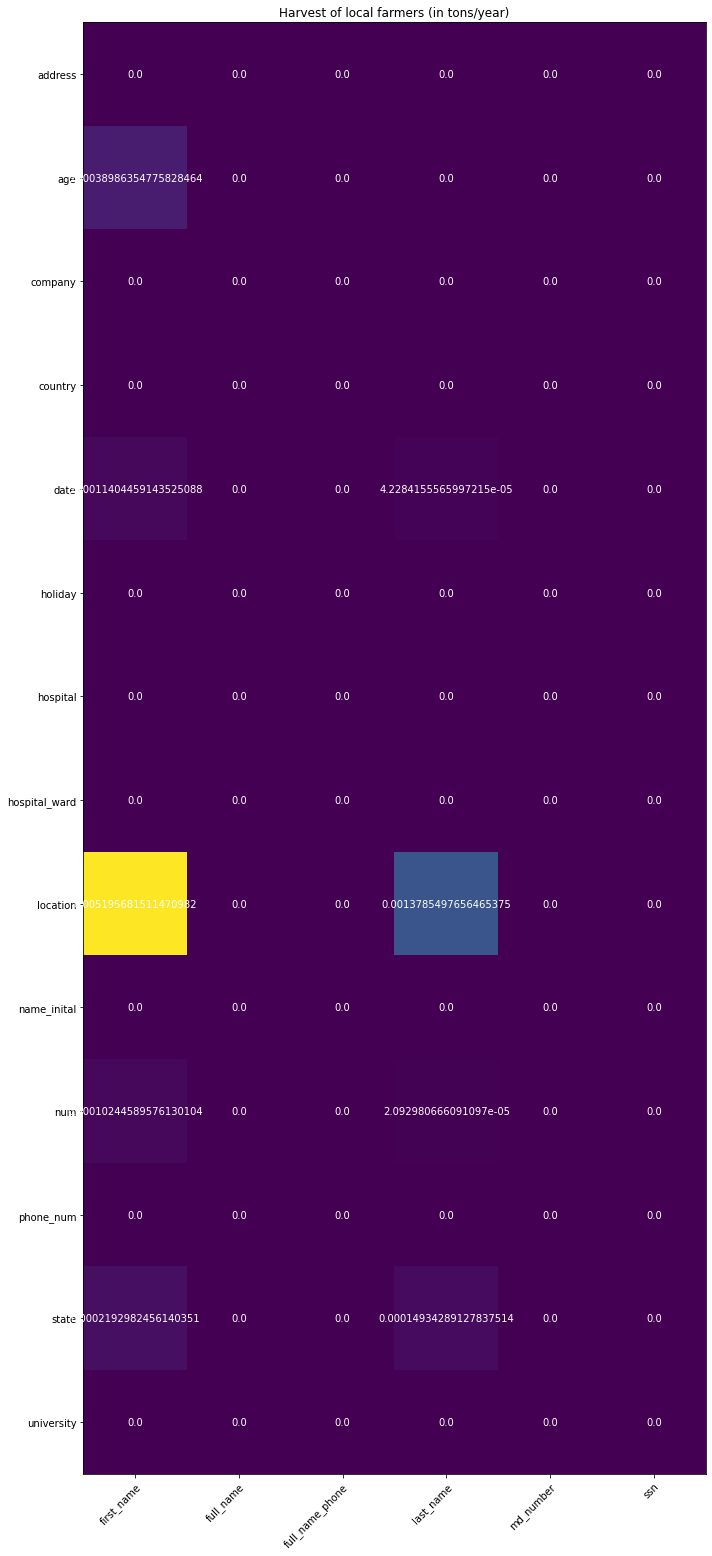

In [124]:
row_ls = f_df.index
col_ls = f_df.columns

matrix = f_df.values
# fig = plt.figure(figsize = (10, 5))
fig, ax = plt.subplots(figsize=(10, 50))
im = ax.imshow(matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(len(col_ls)))
ax.set_yticks(np.arange(len(row_ls)))
# ... and label them with the respective list entries
ax.set_xticklabels(col_ls)
ax.set_yticklabels(row_ls)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(row_ls)):
    for j in range(len(col_ls)):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

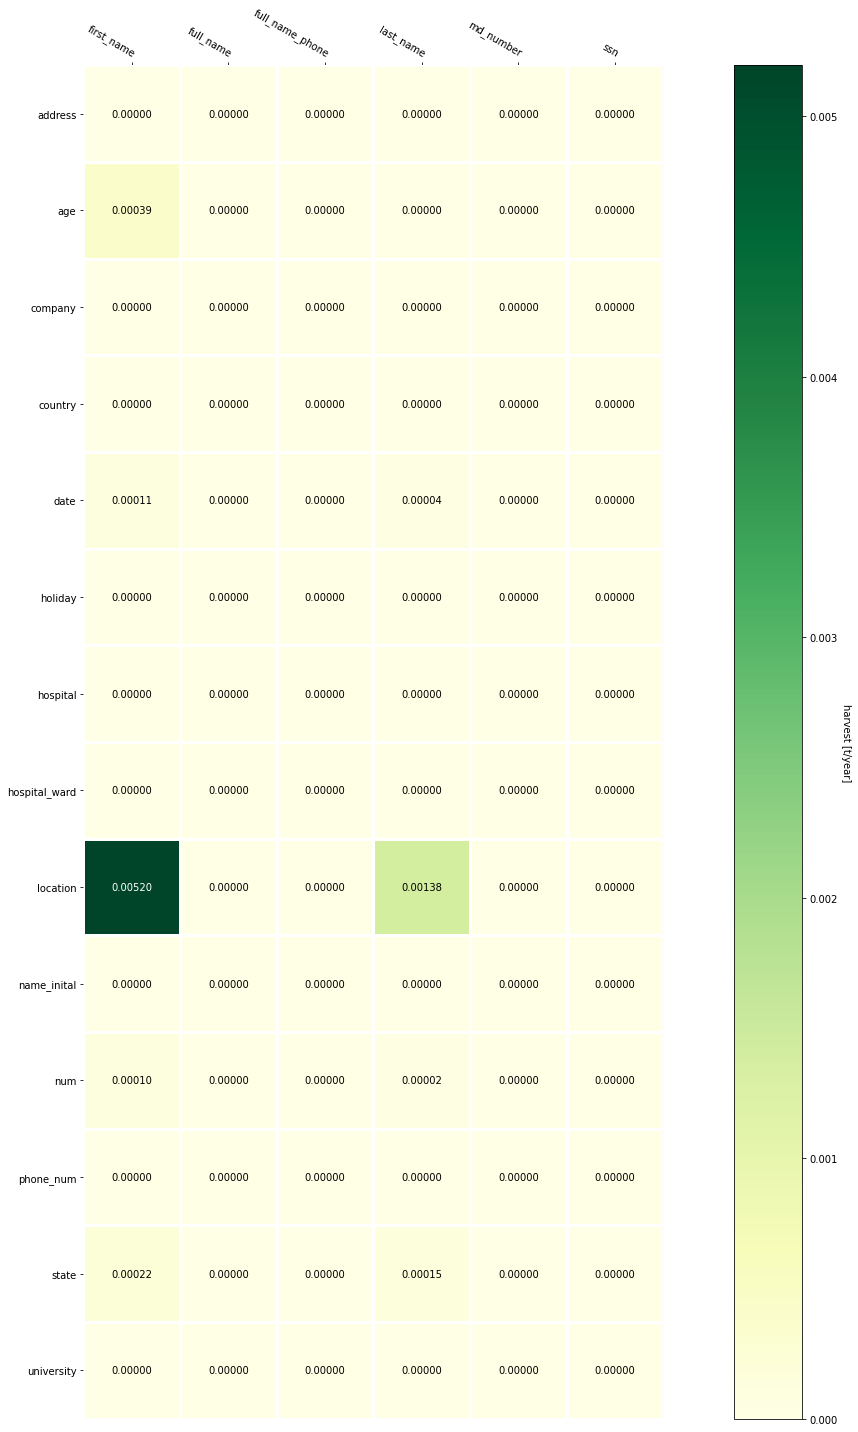

In [130]:
fig, ax = plt.subplots(figsize=(20, 20))

im, cbar = heatmap(matrix, row_ls, col_ls, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.5f}")

fig.tight_layout()
plt.show()

In [125]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Map w/t HIPAA

In [26]:
tmp = {'address',  'age', 'clip_number', 'company', 'country', 'date',
 'first_name', 'full_name', 'holiday', 'hospital', 'hospital_ward',
 'job_number', 'last_name', 'location', 'md_number', 'medical_record_number',
 'name_inital', 'num', 'numeric_identifier', 'pager_number', 'phone_num',
 'serial_number', 'ssn', 'state', 'unit_number', 'university'}

#### HIPAA 18 identifiers [https://www.hhs.gov/hipaa/for-professionals/privacy/special-topics/de-identification/index.html ]


(A) Names

(B) All_geo geographic subdivisions smaller than a state, including street address, city, county, precinct, ZIP code, and their equivalent geocodes, except for the initial three digits of the ZIP code if, according to the current publicly available data from the Bureau of the Census:

(C) All_date elements of dates (except year) for dates that are directly related to an individual, including birth date, admission date, discharge date, death date, and all ages over 89 and all elements of dates (including year) indicative of such age, except that such ages and elements may be aggregated into a single category of age 90 or older

(D) Telephone numbers

(L) Vehicle identifiers and serial numbers, including license plate numbers

(E) Fax numbers

(M) Device identifiers and serial numbers

(F) Email addresses

(N) Web Universal Resource Locators (URLs)

(G) Social security numbers

(O) Internet Protocol (IP) addresses

(H) Medical record numbers

(P) Biometric identifiers, including finger and voice prints

(I) Health plan beneficiary numbers

(Q) Full-face photographs and any comparable images

(J) Account numbers

(R) Any other unique identifying number, characteristic, or code, except as permitted by paragraph (c) of this section [Paragraph (c) is presented below in the section “Re-identification”]; and

(K) Certificate/license numbers

#### Mapping

In [44]:
tmp = list(tmp)
tmp.sort()
keys = list(MAP_2_HIPAA.keys())
keys.sort()
print(len(tmp) , len(keys))
list(zip(tmp, keys))

26 26


[('address', 'address'),
 ('age', 'age'),
 ('clip_number', 'clip_number'),
 ('company', 'company'),
 ('country', 'country'),
 ('date', 'date'),
 ('first_name', 'first_name'),
 ('full_name', 'full_name'),
 ('holiday', 'holiday'),
 ('hospital', 'hospital'),
 ('hospital_ward', 'hospital_ward'),
 ('job_number', 'job_number'),
 ('last_name', 'last_name'),
 ('location', 'location'),
 ('md_number', 'md_number'),
 ('medical_record_number', 'medical_record_number'),
 ('name_inital', 'name_inital'),
 ('num', 'num'),
 ('numeric_identifier', 'numeric_identifier'),
 ('pager_number', 'pager_number'),
 ('phone_num', 'phone_num'),
 ('serial_number', 'serial_number'),
 ('ssn', 'ssn'),
 ('state', 'state'),
 ('unit_number', 'unit_number'),
 ('university', 'university')]

In [558]:
MAP_2_HIPAA = {
'address': 'All_geo', #2
'age': 'All_date', #3,
'clip_number': 'Unique_identifying_number',
'company': 'All_geo', #17
'country': 'All_geo', #2
'date': 'All_date', #3
'first_name': 'Names', #1
'full_name': 'Names', #1
'holiday': 'All_date',
'last_name': 'Names', #1
# 'full_name_phone': 'Names', 'Telephone', #1 #4 
'holiday': 'All_date', #3
'hospital': 'All_geo', #2
'hospital_ward': 'All_geo', #2
'job_number': 'Unique_identifying_number',
'location': 'All_geo', #2
'md_number': 'Unique_identifying_number', #17
'medical_record_number': 'Medical_record_numbers',
'name_inital': 'Names', #1
'num': 'Unique_identifying_number', #17
'numeric_identifier': 'Unique_identifying_number',
'pager_number': 'Telephone',
'phone_num': 'Telephone', #4
'serial_number': 'Device_identifiers', #7
'ssn': 'SSN', #10
'state': 'All_geo', #2
'unit_number': 'Unique_identifying_number',
'university': 'All_geo', #17
}


In [49]:
hipaa_ls = ['Names', #1
'All_geo', #2
'All_date', #3
'Telephone', #4
'Vehicle_serial_license', #5
'Fax_num', #6
'Device_identifiers', #7
'Email', #8
'Web_URLs', #9
'SSN', #10
'IP_address', #11
'Medical_record_numbers', #12
'Biometric_identifiers', #13
'Health_plan_beneficiary_numbers', #14
'Images', #15
'Account_numbers', #16
'Unique_identifying_number', #17
'Certificate_license_num', #18
]

In [12]:
root = r'./re_id_history/'
result_csv = os.path.join(root, 'insert_hipaa_result.csv')
df = pd.read_csv(result_csv)
df = df.rename({'Unnamed: 0': 'icd9'}, axis=1)

In [13]:
df.head()

,icd9,Names,All_geo,All_date,Telephone,Vehicle_identifiers,Fax_num,Device_identifiers,Email,Web_URLs,SSN,IP_address,Medical_record_numbers,Biometric_identifiers,Health plan beneficiary numbers,Images,Account_numbers,Unique_identifying_number,Certificate_license_num
0,acute respiratry failure.json,2390,2045,1126,651,0,0,0,0,0,1,0,0,0,0,0,0,1043,0
1,aqcute kidney failure.json,2412,2219,1161,794,0,0,0,0,0,4,0,0,0,0,0,0,981,0
2,atrial fibrillation.json,2259,1903,1093,687,0,0,0,0,0,0,0,0,0,0,0,0,960,0
3,congestive heart failure.json,2267,1764,1073,598,0,0,0,0,0,1,0,0,0,0,0,0,1197,0
4,coronary atherosclerosis.json,2243,1821,1034,624,0,0,0,0,0,1,0,0,0,0,0,0,1066,0
